# Scalable Constrained Bayesian Optimization (SCBO)
In this tutorial, we show how to implement Scalable Constrained Bayesian Optimization (SCBO) [1] in a closed loop in BoTorch.

We optimize the 10𝐷 Ackley function on the domain $[−5,10]^{10}$. This implementation uses two simple constraint functions $c1$ and $c2$. Our goal is to find an $x$ that maximizes the Ackley function subject to the constraints $c1(x) \leq 0$ and $c2(x) \leq 0$.

[1]: David Eriksson and Matthias Poloczek. Scalable constrained Bayesian optimization. In International Conference on Artificial Intelligence and Statistics, pages 730–738. PMLR, 2021.
(https://doi.org/10.48550/arxiv.2002.08526)

Since SCBO is essentially a constrained version of Trust Region Bayesian Optimization (TuRBO), this tutorial shares much of the same code as the TuRBO Tutorial (https://botorch.org/docs/tutorials/turbo_1) with small modifications made to implement SCBO.

In [1]:
# Install dependencies if we are running in colab
import sys
if 'google.colab' in sys.modules:
    %pip install botorch

In [2]:
import math
import os
import warnings
from dataclasses import dataclass

import gpytorch
import torch
from gpytorch.constraints import Interval
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from torch import Tensor
from torch.quasirandom import SobolEngine

from botorch.fit import fit_gpytorch_mll
# Constrained Max Posterior Sampling s a new sampling class, similar to MaxPosteriorSampling,
# which implements the constrained version of Thompson Sampling described in [1].
from botorch.generation.sampling import ConstrainedMaxPosteriorSampling
from botorch.models import SingleTaskGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.test_functions import Ackley
from botorch.utils.transforms import unnormalize

warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double
tkwargs = {"device": device, "dtype": dtype}

SMOKE_TEST = os.environ.get("SMOKE_TEST")


[KeOps] Warning : There were warnings or errors :
/bin/sh: brew: command not found

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.

[KeOps] Warning : There were warnings or errors :
/bin/sh: brew: command not found

[KeOps] Warning : OpenMP library not found, it must be downloaded through Homebrew for apple Silicon chips
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


## Demonstration with 10-dimensional Ackley function and Two Simple Constraint Functions

In [3]:
# Here we define the example 10D Ackley function
fun = Ackley(dim=10, negate=True).to(**tkwargs)
fun.bounds[0, :].fill_(-5)
fun.bounds[1, :].fill_(10)
dim = fun.dim
lb, ub = fun.bounds

batch_size = 4
n_init = 10
max_cholesky_size = float("inf")  # Always use Cholesky

# When evaluating the function, we must first unnormalize the inputs since
# we will use normalized inputs x in the main optimizaiton loop
def eval_objective(x):
    """This is a helper function we use to unnormalize and evalaute a point"""
    return fun(unnormalize(x, fun.bounds))

### Defining two simple constraint functions

#### We'll use two constraints functions: c1 and c2 
We want to find solutions which maximize the above Ackley objective subject to the constraint that 
c1(x) <= 0 and c2(x) <= 0 
Note that SCBO expects all constraints to be of the for c(x) <= 0, so any other desired constraints must be modified to fit this form. 

Note also that while the below constraints are very simple functions, the point of this tutorial is to show how to use SCBO, and this same implementation could be applied in the same way if c1, c2 were actually complex black-box functions. 


In [4]:
def c1(x):  # Equivalent to enforcing that sum(x) <= 0
    return x.sum()


def c2(x):  # Equivalent to enforcing that ||x||_2 <= 5
    return torch.norm(x, p=2) - 5


# We assume c1, c2 have same bounds as the Ackley function above
def eval_c1(x):
    """This is a helper function we use to unnormalize and evalaute a point"""
    return c1(unnormalize(x, fun.bounds))


def eval_c2(x):
    """This is a helper function we use to unnormalize and evalaute a point"""
    return c2(unnormalize(x, fun.bounds))

## Define TuRBO Class

Just as in the TuRBO Tutorial (https://botorch.org/docs/tutorials/turbo_1), we'll define a class to hold the turst region state and a method update_state() to update the side length of the trust region hyper-cube during optimization. We'll update the side length according to the number of sequential successes or failures as discussed in the original TuRBO paper. 

In [5]:
@dataclass
class ScboState:
    dim: int
    batch_size: int
    length: float = 0.8
    length_min: float = 0.5**7
    length_max: float = 1.6
    failure_counter: int = 0
    failure_tolerance: int = float("nan")  # Note: Post-initialized
    success_counter: int = 0
    success_tolerance: int = 10  # Note: The original paper uses 3
    best_value: float = -float("inf")
    best_constraint_values: Tensor = torch.ones(2, **tkwargs) * torch.inf
    restart_triggered: bool = False

    def __post_init__(self):
        self.failure_tolerance = math.ceil(max([4.0 / self.batch_size, float(self.dim) / self.batch_size]))


def update_tr_length(state: ScboState):
    # Update the length of the trust region according to
    # success and failure counters
    # (Just as in original TuRBO paper)
    if state.success_counter == state.success_tolerance:  # Expand trust region
        state.length = min(2.0 * state.length, state.length_max)
        state.success_counter = 0
    elif state.failure_counter == state.failure_tolerance:  # Shrink trust region
        state.length /= 2.0
        state.failure_counter = 0

    if state.length < state.length_min:  # Restart when trust region becomes too small
        state.restart_triggered = True

    return state


def get_best_index_for_batch(Y: Tensor, C: Tensor):
    """Return the index for the best point."""
    is_feas = (C <= 0).all(dim=-1)
    if is_feas.any():  # Choose best feasible candidate
        score = Y.clone()
        score[~is_feas] = -float("inf")
        return score.argmax()
    return C.clamp(min=0).sum(dim=-1).argmin()


def update_state(state, Y_next, C_next):
    """Method used to update the TuRBO state after each step of optimization.

    Success and failure counters are updated according to the objective values
    (Y_next) and constraint values (C_next) of the batch of candidate points
    evaluated on the optimization step.

    As in the original TuRBO paper, a success is counted whenver any one of the
    new candidate points improves upon the incumbent best point. The key difference
    for SCBO is that we only compare points by their objective values when both points
    are valid (meet all constraints). If exactly one of the two points being compared
    violates a constraint, the other valid point is automatically considered to be better.
    If both points violate some constraints, we compare them inated by their constraint values.
    The better point in this case is the one with minimum total constraint violation
    (the minimum sum of constraint values)"""

    # Pick the best point from the batch
    best_ind = get_best_index_for_batch(Y=Y_next, C=C_next)
    y_next, c_next = Y_next[best_ind], C_next[best_ind]

    if (c_next <= 0).all():
        # At least one new candidate is feasible
        improvement_threshold = state.best_value + 1e-3 * math.fabs(state.best_value)
        if y_next > improvement_threshold or (state.best_constraint_values > 0).any():
            state.success_counter += 1
            state.failure_counter = 0
            state.best_value = y_next.item()
            state.best_constraint_values = c_next
        else:
            state.success_counter = 0
            state.failure_counter += 1
    else:
        # No new candidate is feasible
        total_violation_next = c_next.clamp(min=0).sum(dim=-1)
        total_violation_center = state.best_constraint_values.clamp(min=0).sum(dim=-1)
        if total_violation_next < total_violation_center:
            state.success_counter += 1
            state.failure_counter = 0
            state.best_value = y_next.item()
            state.best_constraint_values = c_next
        else:
            state.success_counter = 0
            state.failure_counter += 1

    # Update the length of the trust region according to the success and failure counters
    state = update_tr_length(state)
    return state


# Define example state
state = ScboState(dim=dim, batch_size=batch_size)
print(state)

ScboState(dim=10, batch_size=4, length=0.8, length_min=0.0078125, length_max=1.6, failure_counter=0, failure_tolerance=3, success_counter=0, success_tolerance=10, best_value=-inf, best_constraint_values=tensor([inf, inf], dtype=torch.float64), restart_triggered=False)


### Generate Initial Points

Here we define a simple method to generate a set of random initial datapoints that we will use to kick-off optimization. 

In [6]:
def get_initial_points(dim, n_pts, seed=0):
    sobol = SobolEngine(dimension=dim, scramble=True, seed=seed)
    X_init = sobol.draw(n=n_pts).to(dtype=dtype, device=device)
    return X_init

### Generating a batch of candidates for SCBO 

Just as in the TuRBO Tutorial (https://botorch.org/docs/tutorials/turbo_1), we'll define a method generate_batch to generate a new batch of candidate points within the TuRBO trust region using Thompson sampling. 

The key difference here from TuRBO is that, instead of using MaxPosteriorSampling to simply grab the candidates within the trust region with the maximum posterior values, we use ConstrainedMaxPosteriorSampling to instead grab the candidates within the trust region with the maximum posterior values subject to the constraint that the posteriors for the constraint models for c1(x) and c2(x) must be less than or equal to 0 for both candidates. 

We use additional GPs ('constraint models') to model each black-box constraint (c1 and c2), and throw out all candidates for which the sampled value for these constraint models is greater than 0. According to [1], in the special case when all of the candidaates are predicted to be constraint violators, we select the candidate with the minimum predicted violation. (See botorch.generation.sampling.ConstrainedMaxPosteriorSampling for implementation details).

In [7]:
def generate_batch(
    state,
    model,  # GP model
    X,  # Evaluated points on the domain [0, 1]^d
    Y,  # Function values
    C,  # Constraint values
    batch_size,
    n_candidates,  # Number of candidates for Thompson sampling
    constraint_model,
    sobol: SobolEngine,
):
    assert X.min() >= 0.0 and X.max() <= 1.0 and torch.all(torch.isfinite(Y))

    # Create the TR bounds
    best_ind = get_best_index_for_batch(Y=Y, C=C)
    x_center = X[best_ind, :].clone()
    tr_lb = torch.clamp(x_center - state.length / 2.0, 0.0, 1.0)
    tr_ub = torch.clamp(x_center + state.length / 2.0, 0.0, 1.0)

    # Thompson Sampling w/ Constraints (SCBO)
    dim = X.shape[-1]
    pert = sobol.draw(n_candidates).to(dtype=dtype, device=device)
    pert = tr_lb + (tr_ub - tr_lb) * pert

    # Create a perturbation mask
    prob_perturb = min(20.0 / dim, 1.0)
    mask = torch.rand(n_candidates, dim, **tkwargs) <= prob_perturb
    ind = torch.where(mask.sum(dim=1) == 0)[0]
    mask[ind, torch.randint(0, dim - 1, size=(len(ind),), device=device)] = 1

    # Create candidate points from the perturbations and the mask
    X_cand = x_center.expand(n_candidates, dim).clone()
    X_cand[mask] = pert[mask]

    # Sample on the candidate points using Constrained Max Posterior Sampling
    constrained_thompson_sampling = ConstrainedMaxPosteriorSampling(
        model=model, constraint_model=constraint_model, replacement=False
    )
    with torch.no_grad():
        X_next = constrained_thompson_sampling(X_cand, num_samples=batch_size)

    return X_next

## Main Optimization Loop

In [8]:
# Generate initial data
train_X = get_initial_points(dim, n_init)
train_Y = torch.tensor([eval_objective(x) for x in train_X], **tkwargs).unsqueeze(-1)
C1 = torch.tensor([eval_c1(x) for x in train_X], **tkwargs).unsqueeze(-1)
C2 = torch.tensor([eval_c2(x) for x in train_X], **tkwargs).unsqueeze(-1)

# Initialize TuRBO state
state = ScboState(dim, batch_size=batch_size)

# Note: We use 2000 candidates here to make the tutorial run faster.
# SCBO actually uses min(5000, max(2000, 200 * dim)) candidate points by default.
N_CANDIDATES = 2000 if not SMOKE_TEST else 4
sobol = SobolEngine(dim, scramble=True, seed=1)


def get_fitted_model(X, Y):
    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
    covar_module = ScaleKernel(  # Use the same lengthscale prior as in the TuRBO paper
        MaternKernel(nu=2.5, ard_num_dims=dim, lengthscale_constraint=Interval(0.005, 4.0))
    )
    model = SingleTaskGP(
        X,
        Y,
        covar_module=covar_module,
        likelihood=likelihood,
    )
    mll = ExactMarginalLogLikelihood(model.likelihood, model)

    with gpytorch.settings.max_cholesky_size(max_cholesky_size):
        fit_gpytorch_mll(mll)

    return model


while not state.restart_triggered:  # Run until TuRBO converges
    # Fit GP models for objective and constraints
    model = get_fitted_model(train_X, train_Y)
    c1_model = get_fitted_model(train_X, C1)
    c2_model = get_fitted_model(train_X, C2)

    # Generate a batch of candidates
    with gpytorch.settings.max_cholesky_size(max_cholesky_size):
        X_next = generate_batch(
            state=state,
            model=model,
            X=train_X,
            Y=train_Y,
            C=torch.cat((C1, C2), dim=-1),
            batch_size=batch_size,
            n_candidates=N_CANDIDATES,
            constraint_model=ModelListGP(c1_model, c2_model),
            sobol=sobol,
        )

    # Evaluate both the objective and constraints for the selected candidaates
    Y_next = torch.tensor([eval_objective(x) for x in X_next], dtype=dtype, device=device).unsqueeze(-1)
    C1_next = torch.tensor([eval_c1(x) for x in X_next], dtype=dtype, device=device).unsqueeze(-1)
    C2_next = torch.tensor([eval_c2(x) for x in X_next], dtype=dtype, device=device).unsqueeze(-1)
    C_next = torch.cat([C1_next, C2_next], dim=-1)

    # Update TuRBO state
    state = update_state(state=state, Y_next=Y_next, C_next=C_next)

    # Append data. Note that we append all data, even points that violate
    # the constraints. This is so our constraint models can learn more
    # about the constraint functions and gain confidence in where violations occur.
    train_X = torch.cat((train_X, X_next), dim=0)
    train_Y = torch.cat((train_Y, Y_next), dim=0)
    C1 = torch.cat((C1, C1_next), dim=0)
    C2 = torch.cat((C2, C2_next), dim=0)

    # Print current status. Note that state.best_value is always the best
    # objective value found so far which meets the constraints, or in the case
    # that no points have been found yet which meet the constraints, it is the
    # objective value of the point with the minimum constraint violation.
    if (state.best_constraint_values <= 0).all():
        print(f"{len(train_X)}) Best value: {state.best_value:.2e}, TR length: {state.length:.2e}")
    else:
        violation = state.best_constraint_values.clamp(min=0).sum()
        print(
            f"{len(train_X)}) No feasible point yet! Smallest total violation: "
            f"{violation:.2e}, TR length: {state.length:.2e}"
        )

14) No feasible point yet! Smallest total violation: 1.48e+01, TR length: 8.00e-01


18) No feasible point yet! Smallest total violation: 8.08e+00, TR length: 8.00e-01


22) No feasible point yet! Smallest total violation: 6.13e+00, TR length: 8.00e-01


26) No feasible point yet! Smallest total violation: 2.94e+00, TR length: 8.00e-01


30) No feasible point yet! Smallest total violation: 2.29e+00, TR length: 8.00e-01


34) No feasible point yet! Smallest total violation: 2.29e+00, TR length: 8.00e-01


38) No feasible point yet! Smallest total violation: 1.78e+00, TR length: 8.00e-01


42) No feasible point yet! Smallest total violation: 1.78e+00, TR length: 8.00e-01


46) No feasible point yet! Smallest total violation: 1.78e+00, TR length: 8.00e-01


50) No feasible point yet! Smallest total violation: 1.36e-01, TR length: 8.00e-01


54) Best value: -6.49e+00, TR length: 8.00e-01


58) Best value: -6.49e+00, TR length: 8.00e-01


62) Best value: -6.49e+00, TR length: 8.00e-01


66) Best value: -5.29e+00, TR length: 8.00e-01


70) Best value: -5.29e+00, TR length: 8.00e-01


74) Best value: -5.29e+00, TR length: 8.00e-01


78) Best value: -5.29e+00, TR length: 4.00e-01


82) Best value: -4.79e+00, TR length: 4.00e-01


86) Best value: -4.79e+00, TR length: 4.00e-01


90) Best value: -4.63e+00, TR length: 4.00e-01


94) Best value: -4.63e+00, TR length: 4.00e-01


98) Best value: -4.62e+00, TR length: 4.00e-01


102) Best value: -4.50e+00, TR length: 4.00e-01


106) Best value: -4.50e+00, TR length: 4.00e-01


110) Best value: -4.50e+00, TR length: 4.00e-01


114) Best value: -4.12e+00, TR length: 4.00e-01


118) Best value: -4.12e+00, TR length: 4.00e-01


122) Best value: -3.43e+00, TR length: 4.00e-01


126) Best value: -3.43e+00, TR length: 4.00e-01


130) Best value: -3.43e+00, TR length: 4.00e-01


134) Best value: -3.43e+00, TR length: 2.00e-01


138) Best value: -3.43e+00, TR length: 2.00e-01


142) Best value: -3.43e+00, TR length: 2.00e-01


146) Best value: -3.12e+00, TR length: 2.00e-01


150) Best value: -3.09e+00, TR length: 2.00e-01


154) Best value: -3.09e+00, TR length: 2.00e-01


158) Best value: -3.09e+00, TR length: 2.00e-01


162) Best value: -2.80e+00, TR length: 2.00e-01


166) Best value: -2.80e+00, TR length: 2.00e-01


170) Best value: -2.80e+00, TR length: 2.00e-01


174) Best value: -2.80e+00, TR length: 1.00e-01


178) Best value: -2.80e+00, TR length: 1.00e-01


182) Best value: -2.80e+00, TR length: 1.00e-01


186) Best value: -2.74e+00, TR length: 1.00e-01


190) Best value: -2.51e+00, TR length: 1.00e-01


194) Best value: -1.59e+00, TR length: 1.00e-01


198) Best value: -1.59e+00, TR length: 1.00e-01


202) Best value: -1.59e+00, TR length: 1.00e-01


206) Best value: -1.59e+00, TR length: 5.00e-02


210) Best value: -1.46e+00, TR length: 5.00e-02


214) Best value: -1.46e+00, TR length: 5.00e-02


218) Best value: -1.29e+00, TR length: 5.00e-02


222) Best value: -1.27e+00, TR length: 5.00e-02


226) Best value: -1.26e+00, TR length: 5.00e-02


230) Best value: -1.07e+00, TR length: 5.00e-02


234) Best value: -1.01e+00, TR length: 5.00e-02


238) Best value: -1.01e+00, TR length: 5.00e-02


242) Best value: -1.01e+00, TR length: 5.00e-02


246) Best value: -6.57e-01, TR length: 5.00e-02


250) Best value: -6.57e-01, TR length: 5.00e-02


254) Best value: -6.57e-01, TR length: 5.00e-02


258) Best value: -6.57e-01, TR length: 2.50e-02


262) Best value: -5.06e-01, TR length: 2.50e-02


266) Best value: -3.74e-01, TR length: 2.50e-02


270) Best value: -3.74e-01, TR length: 2.50e-02


274) Best value: -2.90e-01, TR length: 2.50e-02


278) Best value: -2.90e-01, TR length: 2.50e-02


282) Best value: -2.90e-01, TR length: 2.50e-02


286) Best value: -2.90e-01, TR length: 1.25e-02


290) Best value: -1.61e-01, TR length: 1.25e-02


294) Best value: -1.39e-01, TR length: 1.25e-02


298) Best value: -1.09e-01, TR length: 1.25e-02


302) Best value: -1.09e-01, TR length: 1.25e-02


306) Best value: -9.68e-02, TR length: 1.25e-02


310) Best value: -9.68e-02, TR length: 1.25e-02


314) Best value: -9.68e-02, TR length: 1.25e-02


318) Best value: -9.68e-02, TR length: 6.25e-03


### Plot Results

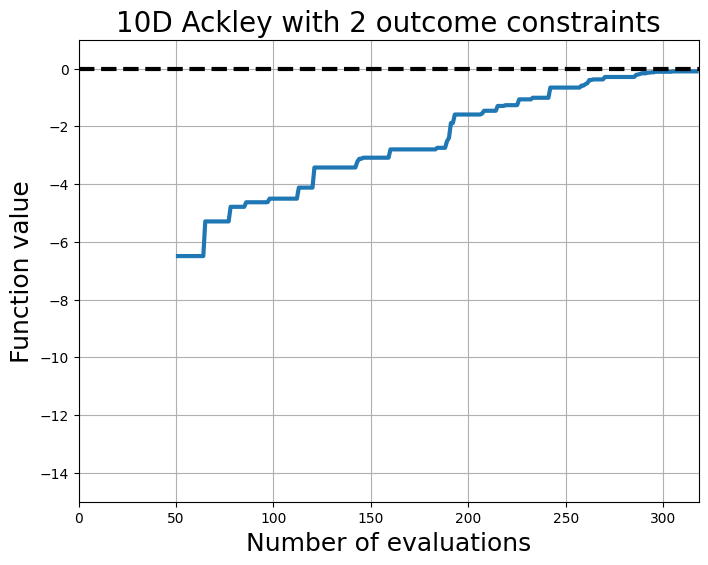

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc

%matplotlib inline

fig, ax = plt.subplots(figsize=(8, 6))

score = train_Y.clone()
# Set infeasible to -inf
score[~(torch.cat((C1, C2), dim=-1) <= 0).all(dim=-1)] = float("-inf")
fx = np.maximum.accumulate(score.cpu())
plt.plot(fx, marker="", lw=3)

plt.plot([0, len(train_Y)], [fun.optimal_value, fun.optimal_value], "k--", lw=3)
plt.ylabel("Function value", fontsize=18)
plt.xlabel("Number of evaluations", fontsize=18)
plt.title("10D Ackley with 2 outcome constraints", fontsize=20)
plt.xlim([0, len(train_Y)])
plt.ylim([-15, 1])

plt.grid(True)
plt.show()